### Imports

In [1]:
import pandas as pd
import re
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.tools as tls


# Capstone Research
### Tim Holthuijsen
This is the Empirical Climate Model Research accompanying my AUC capstone. In this Jupyter Notebook, I will perform multiple types of error analysis on Climate Model Outputs in order to quanity and recognize patterns in climate model error. I will then use a combination of Machine Learning, Deep Learning and statistical techniques to start predict and reduce these patterns of Climate Model errors, thus yielding an Algorithm for Climate Model Improvement, which will be the final product of my Capstone.

# Geographic Analysis
We start this analysis by Spatially analyzing the Global Ensemble Forecast Systems (GEFS) climate Reforecasts

We can begin this analysis after loading reforecast temperature NetCDF dataset into the reforecast variable

In [2]:
import netCDF4 as nc
path = '/CapstoneGIS/Reforecast_tmp_2m.nc'
reforecast = nc.Dataset(path)

In [3]:
print(reforecast)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.0
    title: Subset of data from 2nd-generation multi-decadal ensemble reforecast generated from the NCEP Global Ensemble Forecast System, mimicking version operational at NCEP/EMC circa mid-2012.
    institution: NOAA Earth System Research Laboratory (ESRL)
    source: NCEP GFS v 9.01, T254L42.  Control initial conditions from CFSRR.  Perturbed initial conditions from ETR.  Model error simulated with STTP.
    references: http://www.esrl.noaa.gov/psd/forecasts/reforecast2/index.html
    history: Subset created 2020-09-16 19:56:10 UTC
    comment: Original dataset generated on DOE's supercomputers at Lawrence Berkeley Laboratory through ALCC/ASCR grant.
    dimensions(sizes): time(12892), lat(181), lon(360), fhour(5)
    variables(dimensions): float64 time(time), int32 intTime(time), float32 lat(lat), float32 lon(lon), int32 fhour(fhour), int32 intValidTime(time, fhour), 

Setting the lons, lats, and temp variables for the dataset

In [4]:
lons = reforecast.variables['lon'][:]
lats = reforecast.variables['lat'][:]
#We initially remove the time dimension from temp so we can display it in 2D
temp = reforecast.variables['Temperature_height_above_ground'][0,0,:,:]


temp_units = reforecast.variables['Temperature_height_above_ground'].units

Now we can Plot the temperature in the Reforecast dataset along its respective longtitude and latitude, using the Cartopy package on a Plate Carrée map transform.

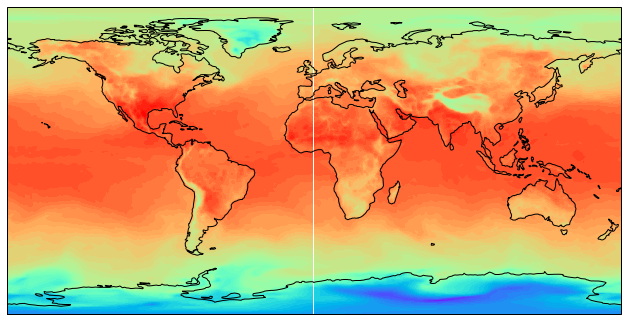

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, temp, 60, cmap = 'rainbow',
             transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

### Reanalysis
We can now repeat this process to get the Reanalysis data mapped out:

In [6]:
pathreanalysis = '/CapstoneGIS/Reanalysis_2mtempNC.nc'
reanalysis = nc.Dataset(pathreanalysis)

In [7]:
print(reanalysis)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2020-09-16 04:55:14 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data4/adaptor.mars.internal-1600230107.3973272-25431-19-f93c8760-6f1c-406a-8f4c-b12b8c12304f.nc /cache/tmp/f93c8760-6f1c-406a-8f4c-b12b8c12304f-adaptor.mars.internal-1600230107.3978748-25431-6-tmp.grib
    dimensions(sizes): longitude(1440), latitude(721), expver(2), time(488)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 t2m(time, expver, latitude, longitude)
    groups: 


In [8]:
lonsr = reanalysis.variables['longitude'][:]
latsr = reanalysis.variables['latitude'][:]
#We initially remove the time dimension from temp so we can display it in 2D
tempr = reanalysis.variables['t2m'][0,0,:,:]



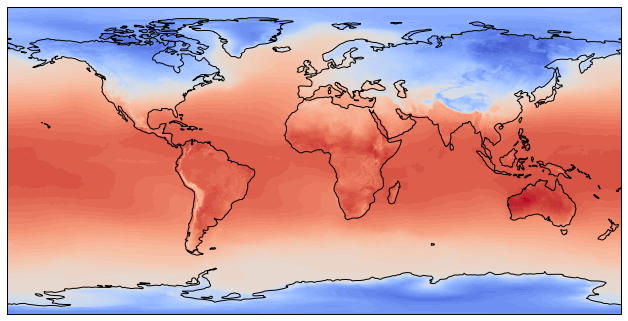

In [9]:
plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lonsr, latsr, tempr, 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())

ax.coastlines()

plt.show()

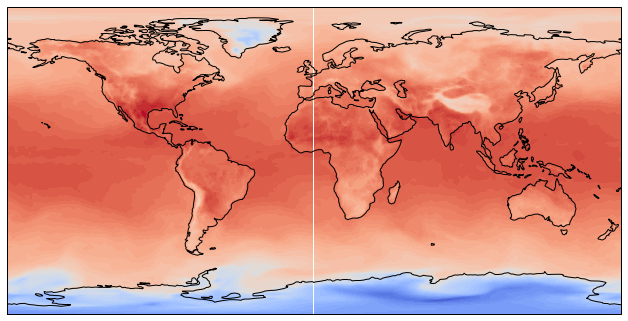

In [10]:
#Repeat the reforecast once more so we can compare them side-by-side
plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, temp, 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

From this initial comparison between the pictures, it already becomes apparent that the datasets seem rather different. However, at the moment, a large part of this difference can also be attributed to the fact that the datasets are not displaying the global temperature at exactly the same time. In order to get these maps to show the same point in time, we have to get the time variable sorted out:

In [11]:
ReanalysisTempTime = reanalysis.variables['t2m'][:,0,:,:]
ReforecastTempTime = reforecast.variables['Temperature_height_above_ground'][:,0,:,:]
timereforecast = reforecast.variables['time'][:]
timereanalysis = reanalysis.variables['time'][:]

In [12]:
#We use the .units function to figure out what format the time is written in
reforecasttimeunits = reforecast.variables['time'].units
print(reforecasttimeunits)
reanalysistimeunits = reanalysis.variables['time'].units
print(reanalysistimeunits)

hours since 1800-01-01 00:00:00
hours since 1900-01-01 00:00:00.0


So as we can see above, the reforecast's time variable is set in number of hourse since 1800-01-01, while the reanalysis shows number of hours since 1900-01-01. To get these into the same format, some converting will need to be done:

In [13]:
print("reforecast time unit minimum is:",min(timereforecast), "maximum is:",max(timereforecast))
print("reanalyisis time unit minimum is:",min(timereanalysis),"maximum is:",max(timereanalysis))

reforecast time unit minimum is: 1625304.0 maximum is: 1934688.0
reanalyisis time unit minimum is: 701256 maximum is: 1057008


There is exactly a 100-year difference between the two datasets time units. We can use this to our advantage in converting them:

In [14]:
#calculating the number of hours in a year
HoursPerYear = 24 * 365.25
#number of hours per year times 100 years is how the data needs to be adjusted
adjustment = HoursPerYear * 1001

In [15]:
#And then we use this adjustment to get the two datasets into the same format
adjustedtimereanalysis = timereanalysis + adjustment

In [16]:
print("reforecast time unit minimum is:",min(timereforecast), "maximum is:",max(timereforecast))
print("reanalyisis time unit minimum is:",min(adjustedtimereanalysis),"maximum is:",max(adjustedtimereanalysis))

reforecast time unit minimum is: 1625304.0 maximum is: 1934688.0
reanalyisis time unit minimum is: 9476022.0 maximum is: 9831774.0


As shown above, the datasets overlap for the largest part now, which is exactly as was to be expected. The overlap is not perfect because the reforecast dataset goes from 1-6-1985 until 16-9-1985 while the reanalysis dataset goes from 1-1-1980 until 1-8-2020.
We will therefore only use the overlapping timeslot for our analysis: from 1-6-1985 until 1-8-2020. Or, in Netcdf time units: from 1625304 until 1933608

### Data organization
Because we have transformed and converted all datasets a lot, we do a quick reorganization to get all of the data we will be working with in the same nameformat

In [17]:
#Setting Time variables for both datasets
ReforecastTime = timereforecast
ReanalysisTime = adjustedtimereanalysis

#Setting Temperature variables
ReforecastTemp = temp
ReanalysisTemp = tempr

#Setting Temp variables preserving time
#ReforecastTempTime = reforecast.variables['Temperature_height_above_ground'][:,:,:,:]
#ReanalysisTempTime = reanalysis.variables['t2m'][:,:,:,:]

#longitude
ReforecastLon = lons
ReanalysisLon = lonsr

#Latitude
ReforecastLat = lats
ReanalysisLat = latsr

In [18]:
ReforecastTempTime.shape

(12892, 181, 360)

In [19]:
#Duurt heel lang om te laden (~20-30 minuten), maar doet het wel
#Figuur 2
df_major_cities = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

df_major_cities['dt'] = df_major_cities['dt'].str.extract(r'((\d)(\d)(\d)(\d))')

# drop columns with NaN
df_major_cities = df_major_cities.dropna(how='any')
df_major_cities = df_major_cities.reset_index(drop=True)

major_cities_years = df_major_cities['dt'].unique()
major_cities_unique = df_major_cities['City'].unique()

In [20]:
major_cities_unique

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Aleppo', 'Alexandria',
       'Ankara', 'Baghdad', 'Bangalore', 'Bangkok', 'Belo Horizonte',
       'Berlin', 'Bogotá', 'Bombay', 'Brasília', 'Cairo', 'Calcutta',
       'Cali', 'Cape Town', 'Casablanca', 'Changchun', 'Chengdu',
       'Chicago', 'Chongqing', 'Dakar', 'Dalian', 'Dar Es Salaam',
       'Delhi', 'Dhaka', 'Durban', 'Faisalabad', 'Fortaleza', 'Gizeh',
       'Guangzhou', 'Harare', 'Harbin', 'Ho Chi Minh City', 'Hyderabad',
       'Ibadan', 'Istanbul', 'Izmir', 'Jaipur', 'Jakarta', 'Jiddah',
       'Jinan', 'Kabul', 'Kano', 'Kanpur', 'Karachi', 'Kiev', 'Kinshasa',
       'Lagos', 'Lahore', 'Lakhnau', 'Lima', 'London', 'Los Angeles',
       'Luanda', 'Madras', 'Madrid', 'Manila', 'Mashhad', 'Melbourne',
       'Mexico', 'Mogadishu', 'Montreal', 'Moscow', 'Nagoya', 'Nagpur',
       'Nairobi', 'Nanjing', 'New Delhi', 'New York', 'Paris', 'Peking',
       'Pune', 'Rangoon', 'Rio De Janeiro', 'Riyadh', 'Rome', 'São Paulo',
       'S

In [21]:
values = np.array(ReforecastTime)/HoursPerYear+1800
values = values.astype(int)
dfTim = pd.DataFrame(values)[0]
dfTim

NameError: name 'np' is not defined

In [ ]:
values = np.array(ReforecastLon)
values = values.astype(int)
dfLon = pd.DataFrame(values)[0]
dfLon

In [ ]:
values = np.array(ReforecastLat)
values = values.astype(int)
dfLat = pd.DataFrame(values)[0]
dfLat

In [ ]:
len(df_test['Longitude'])

In [ ]:
for i, lang in enumerate(df_test['Longitude']):
    if i%10000 == 0:
        temp = ReforecastTemp[i]
        dfLat[i]

In [ ]:
# #Duurt heel lang om te laden (~20-30 minuten), maar doet het wel
# #Figuur 2
# df_major_cities = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

# df_major_cities['dt'] = df_major_cities['dt'].str.extract(r'((\d)(\d)(\d)(\d))')

# # drop columns with NaN
# df_major_cities = df_major_cities.dropna(how='any')
# df_major_cities = df_major_cities.reset_index(drop=True)

# major_cities_years = df_major_cities['dt'].unique()
# major_cities_unique = df_major_cities['City'].unique()
major_cities_years = dfTim

int_year = []
for year in major_cities_years:
    if int(year) >= 2009:
        int_year.append(year)

int_year = sorted(int_year)
major_cities_years = []
for year in int_year:
    major_cities_years.append(str(year))
    
city_temperatures = pd.DataFrame()
city_avg_temp_list = []
data_list = []

for city in major_cities_unique:
    for year in major_cities_years:
        city_year = df_major_cities[(df_major_cities['dt'] == year) & (df_major_cities['City'] == city)]
        city_avg_temp = city_year.AverageTemperature.mean()
        data_list.append([year, city_avg_temp, city_year.City.unique(), city_year.Country.unique(), city_year.Latitude.unique(), city_year.Longitude.unique()])     

df_test = pd.DataFrame(data_list)
df_test = df_test.reset_index(drop=False)
df_test = df_test.drop(columns=['index'])
df_test = df_test.rename(columns = {0:"Year", 1:"AverageTemperature", 2:"City", 3:"Country", 4:"Latitude", 5:"Longitude"})
df_test = df_test.dropna()

df_test.update(df_test.City.str[0])
df_test.update(df_test.Country.str[0])
df_test.update(df_test.Latitude.str[0])
df_test.update(df_test.Longitude.str[0])

df_test = df_test.reset_index(drop=True)

new_lat = []
new_long = []

for lat in df_test.Latitude:
    if re.match(r"\d+\.\d+N", lat):
        new_lat.append(float(re.sub("N", "", lat)))
        
    if re.match(r"\d+\.\d+S", lat):
        int_lat = float(re.sub("S", "", lat))
        lat = int_lat * -1
        new_lat.append(lat1

for long in df_test.Longitude:
    if re.match(r"\d+\.\d+E", long):
        new_long.append(float(re.sub("E", "", long)))
        
    if re.match(r"\d+\.\d+W", long):
        int_long = float(re.sub("W", "", long))
        long = int_long * -1
        new_long.append(long)
        
df_test['new_lat'] = pd.Series(new_lat, index=df_test.index)
df_test['new_long'] = pd.Series(new_long, index=df_test.index)

maxi = max(df_test.AverageTemperature)
mini = min(df_test.AverageTemperature)
scl = [ [0,"rgb(172, 10, 5)"],[0.35,"rgb(190, 60, 40)"],[0.5,"rgb(245, 100, 70)"],\
    [0.6,"rgb(245, 120, 90)"],[0.7,"rgb(247, 137, 106)"],[1,"rgb(244, 226, 66)"] ]

data_slider = []

# om de hoverinfo te laten kloppen
temps = []
for temp in df_test['AverageTemperature']:
    temps.append(str(temp))
df_test['temps'] = pd.Series(temps)
for year in df_test['Year'].unique():
    year_values = df_test[df_test['Year'] == year]
    data_one_year = go.Scattergeo(
        visible = False,
        lon = year_values['new_long'],
        lat = year_values['new_lat'],
        text = year_values['City'] + ', temperatuur is: ' + year_values['temps'],
        mode = 'markers',
        marker = dict( 
            size = 8, 
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,4
            cmin = df_test['AverageTemperature'].min(),
            color = year_values['AverageTemperature'],
            cmax = df_test['AverageTemperature'].max(), #            cmax = year_values['AverageTemperature'].max(),
            
            colorbar=dict(
                title="Temperatuur C°"
            )
    ))
    
    data_slider.append(data_one_year)


df_test['text'] = df_test['City'] + ', ' + df_test['Country'] + '' + 'Average Temperature: ' + df_test['AverageTemperature'].astype(str)

data = data_slider

steps = []

for i in range(3):
    step = dict(
                method='restyle',
                args=['visible', [False] * 163],
                label='{}'.format(i + 2009) # label to be displayed for each step (year)
            )
    step['args'][1][i] = True
    steps.append(step)

    
sliders = [dict(active=1, pad={"t": 1}, steps=steps)]

layout = dict(
    title='Globale temperatuur (1850-2012)',
    sliders=sliders,
    geo = dict(
        scope='world',
        projection = dict(
            type='equirectangular'
        ),
        showland=True,
        landcolor='rgb(235,235,235)',
        subunitcolor='rgb(217,217,217)',
        countrycolor='rgb(100,100,100)',
        countrywidth=0.5,
        subunitwidth=0.5)
)

#Figuur 2
fig = go.Figure(data=data, layout=layout )
iplot(fig)


#### Systematic comparison
As becomes apparent from the differences in these two figures, the reforecast and reanalysis datasets show significantly differing temperatue patterns. In order to compare and quantify the differences in these patterns, we will subtract the Reforecast dataset from the Reanalsysi dataset in order to get the model errors. In order to do this, we first have to get both datasets into the same dimensions, by reducing the resolution of the reanalysis dataset:


In [ ]:
print("Reanalysis shape is now:", tempr.shape, "this needs to be reduced to:", temp.shape)


As becomes apparent from these array shapes, it is the case that the reanalysis' resolution is exactly 4 times larger than that of the Reforecast. Therefore, we will have to reduce the reanalysis' datapoints to 25% of its original size. This will still leave us with more than enough datapoints to perform our analysis, since we will still have 180x360 = 64,800 datapoints per map, over 488 different timeframes, resulting in a total of 64,800 x 488 = 31,622,400 datapoints

In [ ]:
tempr.shape

In [ ]:
reanalysist = tempr[::4,::4]
reforecastt = temp

In [ ]:
if reanalysist.shape == reforecastt.shape:
    print("Reanalysis and reforecast have the same shape!")
else:
    print("Something went wrong! Check your resolution reduction")

Now that we got the reanalysis and reforecast in the same resolution, we can calculate the model error by subtracting the reforecast from the reanalysis array. The value that this yields is the difference between the reforecasted model predictions by the GEFS and the Reanalysis temperature values by ERA5. This is a crude definition of model error, since the reanalysis itself may contain unaccounted model Bias, which could dismantle the validity of this comparison. Therefore we will compare the error data created by our initial error estimation with a more sophisticated error estimation which is based on observational data. If the initial and observational errors appear relatively close to one another we will use the initial error estimation for our analysis since it contains a vast amount of datapoints. If the two error estimations diverge significantly however, we will use an error estimation based on purely observational data instead. But first, we define and calculate our initial error estimation:

In [ ]:
InitialError = reanalysist - reforecastt

In [ ]:
InitialError

In [ ]:
#Repeat the reforecast once more so we can compare them side-by-side
plt.figure(figsize=(11,8.8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lons, lats, InitialError, 60, cmap = 'coolwarm',
             transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

# Error Analysis
Now that we have created an 'error map' of the GEFS reforecast dataset, may different types of error paterns emerge from the above shown map. 

Analysis of these patterns of inaccuracy will be discussed further in the paper

# Statistical Analysis
Now that we have established some patterns in the errors of the Global Ensemble Forecast systems, we can use these patterns in combination with simple statistical methods to try and improve the GEFS' accuracy. 

Using the software ArcMap 10.7.1, we have mapped out these NetCDF files and calculated their errors in the same way as shown above. We then used the software to create a large CSV file called EverythingTable which we load into python to perform some statistical analysis:

In [ ]:
import pandas
table = pandas.read_csv('EverythingTable.csv')
print(table)

the last 50 rows of Landcover and LandcoverCat are NaN. Therefore, we remove them:

In [ ]:
table = table[0:950]

In [ ]:
import statistics
inaccuracy = table['TempInac']
inacmean = statistics.mean(inaccuracy)
temperature = table['Temperature']

We start by quantifying the relationship where higher temperature seems to also yield a higher inaccuracy, and vice versa:

In [ ]:
plt.scatter(temperature, inaccuracy)

Now adding a trendline to the scatter plot:

In [ ]:
import numpy as np
x = temperature
y = inaccuracy
plt.scatter(x,y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

# naming the x axis 
plt.xlabel('Temperature in degrees Kelvin') 
# naming the y axis 
plt.ylabel('Model Discrepancy') 
# naming the graph
plt.title('Model discrepancies against temperature')

plt.show()

# Machine Learning Approach
We now use more sophisticated machine learning techniques provided by Sklearn to improve upon the rudimentary statistical methods used above, and compare their accuracy improvements to determine the most efficient method:

# Deep Learning Neural Network Approach